# Tuning and Validating Model Thresholds

This notebook analyzes optimal classification thresholds for seizure onset detection models by comparing against clinician consensus annotations.

In [1]:
# Enable automatic reloading of modules for development
%load_ext autoreload
%autoreload 2

In [2]:
# Import libraries for data analysis and visualization
import numpy as np
import scipy as sc
import pandas as pd

# Metrics for model evaluation - MCC is primary agreement metric
from sklearn.metrics import matthews_corrcoef

# Plotting libraries for publication-quality figures
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

# Project-specific utilities and configuration
from os.path import join as ospj
from utils import *

from config import Config
prodatapath, figpath = Config.deal(attrs=['prodatapath','figpath'])  # Get data and figure paths

## Clinician Consensus Analysis

Load and process expert clinician annotations to establish ground truth for model evaluation.

In [3]:
# Load consensus annotations from multiple clinicians
consensus_annots = pd.read_pickle(ospj(prodatapath,'threshold_tuning_consensus_v2.pkl'))
consensus_annots.loc[consensus_annots.Seizure_ID == 'HUP249_3','stim'] = 1.0  # Correct stim status for specific seizure
consensus_annots = consensus_annots[consensus_annots.patient != 'CHOP038']   # Exclude problematic patient

In [4]:
# Calculate inter-rater agreement for onset (ueo) annotations
note_type = 'ueo'  # Use "Unequivocal Electrographic Onset" annotations

# For each seizure, compute pairwise MCC between all clinician pairs
for i_r, row in consensus_annots.iterrows():
    scores = 0
    annots = row[note_type]  # List of binary channel annotations from different clinicians
    if len(annots) < 2:  # Need at least 2 annotators
        continue
    
    # Calculate MCC for all pairs of clinicians
    for i_annot in range(len(annots)):
        for j_annot in range(i_annot+1,len(annots)):
            scores += matthews_corrcoef(annots[i_annot],annots[j_annot])
    
    # Average MCC across all pairs
    consensus_annots.loc[i_r,'f1'] = scores/(len(annots)*(len(annots)-1)/2)

# Label for plotting
consensus_annots["model"] = ["Clin."]*len(consensus_annots)
consensus_annots["MCC"] = consensus_annots["f1"]

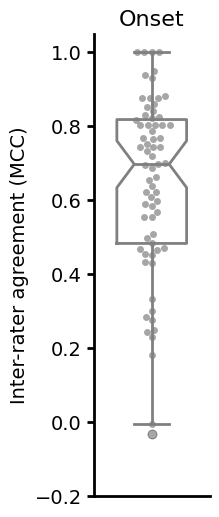

0.6436884593447756


In [5]:
# Plot distribution of inter-rater agreement scores
plt.figure(figsize=(1.5,6))
sns.boxplot(consensus_annots["MCC"],color='gray',fill=False,notch=True,width=0.6)  # Box shows quartiles
sns.swarmplot(consensus_annots["MCC"],color='gray',alpha=0.7)  # Individual points
sns.despine()
plt.title('Onset')
plt.ylabel('Inter-rater agreement (MCC)')
plt.ylim([-.2,1.05])
plt.xticks([])
plt.show()
print(consensus_annots.MCC.mean())  # Print average agreement

## Supervised Thresholding

Optimize model classification thresholds using clinician consensus as ground truth. This section finds the optimal decision thresholds for each patient by maximizing agreement with expert annotations.

### Data prep

Load and configure model predictions with ground truth annotations for threshold optimization.

In [6]:
# Set annotation parameters for model evaluation
anntype='consensus'  # Use consensus ground truth from multiple clinicians
mdl_anntype = 'strict'  # Use strict model predictions (high confidence threshold)
montage = 'bipolar'  # Electrode configuration

# Load pre-computed model predictions with varying classification thresholds
# These predictions were generated across multiple threshold values for optimization
mdl_preds = pd.read_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wmcc_epoch-10_min-False_mov-mean-20-prob_v3.pkl"))
mdl_preds.rename(columns={'Patient':'patient'},inplace=True)  # Standardize column name
mdl_preds.loc[mdl_preds.approximate_onset == 439029.32,'stim'] = 1.0  # Fix stimulation status for specific seizure
mdl_preds = mdl_preds[mdl_preds.patient != 'CHOP015']  # Remove patient with data quality issues


In [7]:
# Print dataset statistics for verification and data quality checks
print('Stim Seizures: ',len(mdl_preds[mdl_preds.stim==1].approximate_onset.unique()))  # Count stimulated seizures
print('All Seizures: ',mdl_preds.approximate_onset.nunique())  # Total seizures in dataset
print('All Patients',len(mdl_preds.patient.unique()))  # Total number of patients
print('HUP Patients', len(mdl_preds[mdl_preds.patient.apply(lambda x: 'HUP' in x)].patient.unique()))  # Hospital of University of Pennsylvania patients
print('HUP Seizures: ', len(mdl_preds[mdl_preds.patient.apply(lambda x: 'HUP' in x)].approximate_onset.unique()))  # HUP seizures

# Temporally align consensus annotations with model predictions using time-based matching
# Uses 120-second tolerance window to account for slight timing differences
x = pd.merge_asof(consensus_annots.sort_values('approximate_onset')[['patient','approximate_onset','clinician']],
mdl_preds.sort_values('approximate_onset'),
on='approximate_onset',by='patient',tolerance=120,direction='nearest')
x['nannot'] = x.clinician.apply(len)  # Count number of annotators per seizure
print('Annotator Distribution: \n',x.groupby('nannot').count()['patient'].reset_index().values)  # Show how many seizures have each number of annotators

Stim Seizures:  37
All Seizures:  81
All Patients 30
HUP Patients 19
HUP Seizures:  63
Annotator Distribution: 
 [[ 1 16]
 [ 2  2]
 [ 3 57]
 [ 5 10]]


In [8]:
# Sort model predictions for consistent processing across patients, seizures, thresholds, and models
# This ensures reproducible results and proper grouping for threshold optimization
mdl_preds_sorted = mdl_preds.sort_values(['patient','approximate_onset','threshold','model'])

In [9]:
# Reshape data from wide to long format for analysis
# Separate columns for onset (ueo) and secondary (sec) channel predictions with MCC scores
melt_cols = [f'ueo_chs_{mdl_anntype}_{anntype}_MCC',f'sec_chs_{mdl_anntype}_{anntype}_MCC']
keep_cols = [c for c in mdl_preds_sorted.columns if c not in melt_cols]
# Transform to long format where each row represents one annotation type per seizure
mdl_preds_long = mdl_preds_sorted.melt(id_vars=keep_cols,var_name='annot',value_name='MCC')

In [10]:
# Split data into tuning and validation sets based on annotation type
# ueo (Unequivocal Electrographic Onset) for threshold tuning
tune_preds_long = mdl_preds_long[mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_MCC']
# sec (Secondary) channels for independent validation of tuned thresholds  
val_preds_long = mdl_preds_long[mdl_preds_long.annot == f'sec_chs_{mdl_anntype}_{anntype}_MCC']

### Tuning at the patient level

Find optimal classification thresholds for each patient individually by maximizing MCC agreement with clinician consensus.

#### Thresholds

Identify optimal decision thresholds by finding the threshold value that maximizes MCC for each patient and stimulation condition.

In [11]:
# Calculate average MCC for each threshold across seizures within patient/model/stimulation groups
avg_MCC_per_threshold = tune_preds_long.groupby(['patient', 'model', 'threshold','stim'])['MCC'].mean().reset_index()

# Find the threshold that maximizes average MCC for each patient, model, and stimulation condition
# This identifies patient-specific and stimulation-specific optimal thresholds
threshold_list = avg_MCC_per_threshold.loc[avg_MCC_per_threshold.groupby(['patient', 'model','stim'])['MCC'].idxmax()]

# Extract just the essential columns: patient, model, stimulation status, and optimal threshold
threshold_list_stim_spec = threshold_list[['patient', 'model', 'stim','threshold']].reset_index(drop=True)

In [12]:
# Save optimized thresholds for future use (currently commented out)
# threshold_list_stim_spec.to_pickle(ospj(prodatapath,'patient_tuned_classification_thresholds_stim_sz-mean_v2.pkl'))

In [13]:
# Filter tuning data to include only the optimal thresholds for each patient/model/stimulation combination
tuned_thresholds = tune_preds_long[tune_preds_long.set_index(['patient', 'model', 'stim','threshold']).index.isin(threshold_list_stim_spec.set_index(['patient', 'model', 'stim','threshold']).index)]
# Apply the same optimal thresholds to validation data for performance evaluation
val_tuned_thresholds = val_preds_long[val_preds_long.set_index(['patient', 'model', 'stim', 'threshold']).index.isin(threshold_list_stim_spec.set_index(['patient', 'model', 'stim','threshold']).index)]

In [14]:
# Alternative approach: merge tuning predictions with optimal thresholds using inner join
# This creates datasets containing only predictions at the optimal threshold for each patient/model
tuned_thresholds = tune_preds_long.merge(threshold_list[['patient', 'model', 'threshold']],on=['patient', 'model', 'threshold'],how='inner').reset_index()
# Stimulation-specific version: includes stimulation status in the merging criteria
tuned_thresholds_stim = tune_preds_long.merge(threshold_list_stim_spec[['patient', 'model', 'stim','threshold']],on=['patient', 'model', 'stim','threshold'],how='inner').reset_index()

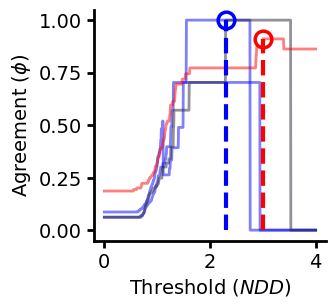

In [15]:
# Visualization: Threshold tuning curves for a representative patient
plot_pt = 'HUP235'  # Example patient for demonstration
_,ax = plt.subplots(figsize=(3,3))

# Plot MCC vs threshold for spontaneous seizures (blue lines, one per seizure)
sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_MCC') &
 (mdl_preds_long.model == 'LSTM') & 
 (mdl_preds_long.patient == plot_pt) & 
 (mdl_preds_long.stim == 0)],x='threshold',y='MCC',hue='approximate_onset', palette = 'dark:b_r', errorbar=None,legend=False,alpha=0.5,ax=ax)

# Plot MCC vs threshold for stimulated seizures (red lines)
sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_MCC') &
 (mdl_preds_long.model == 'LSTM') & 
 (mdl_preds_long.patient == plot_pt) & 
 (mdl_preds_long.stim == 1)],x='threshold',y='MCC', color = 'red', errorbar=None,legend=False,alpha=0.5,ax=ax)

# Mark optimal threshold for spontaneous seizures with vertical line and marker
ax.plot([threshold_list_stim_spec[(threshold_list_stim_spec.patient==plot_pt) & 
(threshold_list_stim_spec.model=='LSTM') & 
(threshold_list_stim_spec.stim==0)].threshold.values]*2,[0,1],'--o',c='blue',
markersize=12,linewidth=3,markevery=[1],fillstyle='none',markeredgewidth=2.5)

# Mark optimal threshold for stimulated seizures with vertical line and marker
ax.plot([
    threshold_list_stim_spec[(threshold_list_stim_spec.patient==plot_pt) & 
    (threshold_list_stim_spec.model=='LSTM') & 
    (threshold_list_stim_spec.stim==1)].threshold.values]*2,
    [0, tuned_thresholds_stim[(tuned_thresholds_stim.model=='LSTM') & 
    (tuned_thresholds_stim.patient==plot_pt) & 
    (tuned_thresholds_stim.stim==1)].MCC.values[0]],
'--o',c='red',markersize=12,linewidth=3,markevery=[1],fillstyle='none',markeredgewidth=2.5)

sns.despine()
ax.set_xlabel('Threshold ($NDD$)')  # NDD = Neural Decoding Detector
ax.set_ylabel('Agreement ($\phi$)')  # φ (phi) = MCC score
plt.savefig(ospj(figpath,'figure_2_Bii.pdf'),bbox_inches='tight')

p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       x: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Custom statistical test, P_val:6.000e-04
Average Optimal Spontaneous Threshold: 1.6322369219565476
Median Optimal Spontaneous Threshold: 1.5246995994659545
LeveneResult(statistic=np.float64(13.31463877664299), pvalue=np.float64(0.0006285218194644076))
Number of rows in non-stim group (stim==0): 22
Number of rows in stim group (stim==1): 30


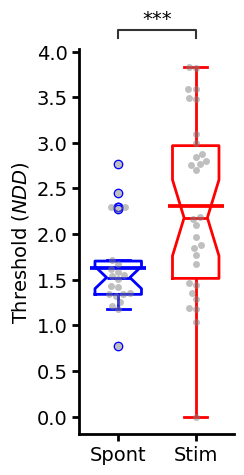

In [16]:
# Compare optimal thresholds between stimulated and spontaneous seizures
_,ax = plt.subplots(figsize=(2,5))

# Filter for LSTM model and exclude problematic patient
plot_thresholds = threshold_list_stim_spec[threshold_list_stim_spec.model == 'LSTM']
plot_thresholds = plot_thresholds[plot_thresholds.patient != 'CHOP015']

# Create comprehensive visualization: swarm plot (individual points) + box plot (distribution) + mean markers
sns.swarmplot(plot_thresholds,x='stim',y='threshold',color='gray',alpha=0.5)  # Individual data points
sns.pointplot(plot_thresholds,x='stim',y='threshold',palette=['blue','red'],
            marker='_',markersize=40,errorbar=None,estimator='mean')  # Mean values as horizontal lines
sns.boxplot(plot_thresholds,x='stim',y='threshold',palette=['blue','red'],width=.6,notch=True,fill=False)  # Distribution quartiles

sns.despine()
plt.xticks([0,1],['Spont','Stim'])  # Label x-axis clearly
plt.xlabel('')
plt.ylabel('Threshold ($NDD$)')

# Add statistical significance annotation
annotator = Annotator(ax,[(True,False)],data=plot_thresholds,x='stim',y='threshold')
annotator.configure(test=None,loc='outside',text_format='star',fontsize=14,
        pvalue_thresholds=[[1e-4, "****"], [1e-3, "***"], [1e-2, "**"], [0.05, "*"], [0.1, "x"],[1, "ns"]])
annotator.set_pvalues([0.0006]).annotate()  # P-value from R statistical analysis

plt.savefig(ospj(figpath,'figure_2_C.pdf'),bbox_inches='tight')

# Print descriptive statistics for interpretation
print(f'Average Optimal Spontaneous Threshold: {plot_thresholds[plot_thresholds.stim == 0].threshold.mean()}')
print(f'Median Optimal Spontaneous Threshold: {plot_thresholds[plot_thresholds.stim == 0].threshold.median()}')
# Test for equal variances between groups using Levene's test
print(sc.stats.levene(plot_thresholds[plot_thresholds.stim==0].threshold,
plot_thresholds[plot_thresholds.stim==1].threshold))
print("Number of rows in non-stim group (stim==0):", plot_thresholds[plot_thresholds.stim == 0].shape[0])
print("Number of rows in stim group (stim==1):", plot_thresholds[plot_thresholds.stim == 1].shape[0])

In [17]:
# Export optimal threshold data for advanced statistical analysis in R
# This enables linear mixed-effects modeling to account for patient-level clustering
plot_thresholds.to_csv(ospj(prodatapath, 'plot_thresholds_for_lme.csv'), index=False)
print(f"Saved plot_thresholds to {ospj(prodatapath, 'plot_thresholds_for_lme.csv')}")
print(f"Columns: {list(plot_thresholds.columns)}")
print(f"Shape: {plot_thresholds.shape}")
print(f"Sample data:")
print(plot_thresholds.head())

Saved plot_thresholds to /Users/wojemann/Documents/CNT/stim_seizures_data/PROCESSED_DATA/plot_thresholds_for_lme.csv
Columns: ['patient', 'model', 'stim', 'threshold']
Shape: (52, 4)
Sample data:
    patient model  stim  threshold
1   CHOP005  LSTM   1.0   3.492657
4   CHOP010  LSTM   1.0   1.970628
7   CHOP024  LSTM   1.0   2.873164
10  CHOP026  LSTM   1.0   2.841121
13  CHOP028  LSTM   1.0   2.098798


#### Benchmark models

Compare optimized model performance against clinician inter-rater agreement and other baseline methods.

In [18]:
# Combine model performance at optimal thresholds with clinician inter-rater agreement
# This creates a unified dataset for comparing automated models against human consensus
all_plot_agreements = pd.concat([tuned_thresholds_stim,consensus_annots[["patient","approximate_onset","model","MCC"]]]).reset_index(drop=True)

In [19]:
# Create paired comparison between model and interrater agreement for the same seizures
# This allows direct statistical comparison of model vs human performance
consensus_annots_df = consensus_annots.copy()
tuned_thresholds_stim_df = tuned_thresholds_stim.copy()
consensus_annots_df['interrater_MCC'] = consensus_annots_df['MCC']  # Rename for clarity
consensus_annots_df.sort_values('approximate_onset', inplace=True)
tuned_thresholds_stim_df.sort_values('approximate_onset', inplace=True)

# Filter for LSTM model results
lstm_thresholds = tuned_thresholds_stim_df[tuned_thresholds_stim_df.model == 'LSTM']

# Temporally match LSTM predictions with corresponding interrater agreements
merged_agreement = pd.merge_asof(
    lstm_thresholds,
    consensus_annots_df[['patient', 'approximate_onset', 'interrater_MCC']],
    on=['approximate_onset'],
    by=['patient'],
    direction='nearest'
)
merged_agreement = merged_agreement.dropna(subset=['MCC', 'interrater_MCC'])  # Remove cases with missing data

# Reshape to long format for statistical analysis
agreement_long = merged_agreement.melt(
    id_vars=['patient', 'approximate_onset', 'model'],
    value_vars=['MCC', 'interrater_MCC'],
    var_name='annotator',
    value_name='Phi'
)
agreement_long.to_csv(ospj(prodatapath, 'model-interrater_agreement.csv'), index=False)
agreement_long.head()

,patient,approximate_onset,model,annotator,Phi
0,HUP229,1109.40,LSTM,MCC,0.693159
1,CHOP010,2230.26,LSTM,MCC,0.487950
2,CHOP035,2872.35,LSTM,MCC,0.867346
3,HUP230,3860.24,LSTM,MCC,0.490566
4,CHOP026,4838.94,LSTM,MCC,0.105017


In [20]:
# Rename models for cleaner visualization and publication
all_plot_agreements.loc[all_plot_agreements.model == 'LSTM',['model']] = 'NDD'  # Neural Decoding Detector
all_plot_agreements.loc[all_plot_agreements.model == 'WVNT',['model']] = 'DL'   # Deep Learning (wavenet)
all_plot_agreements.loc[all_plot_agreements.model == 'Clin.',['model']] = 'Interrater'  # Clinician consensus

In [21]:
# Export onset agreement data for statistical modeling in R  
# Includes model performance and interrater agreement for comparative analysis
onset_all_plot_agreements = all_plot_agreements.copy()
onset_all_plot_agreements['analysis_type'] = 'onset'  # Label analysis type for multi-analysis datasets
onset_all_plot_agreements.to_csv(ospj(prodatapath, 'onset_all_plot_agreements_for_lme.csv'), index=False)
print(f"Saved onset all_plot_agreements to {ospj(prodatapath, 'onset_all_plot_agreements_for_lme.csv')}")
print(f"Columns: {list(onset_all_plot_agreements.columns)}")
print(f"Shape: {onset_all_plot_agreements.shape}")

Saved onset all_plot_agreements to /Users/wojemann/Documents/CNT/stim_seizures_data/PROCESSED_DATA/onset_all_plot_agreements_for_lme.csv
Columns: ['index', 'patient', 'iEEG_ID', 'model', 'stim', 'approximate_onset', 'ueo_time_consensus', 'threshold', 'ueo_chs_strict', 'ueo_chs_loose', 'sec_chs_strict', 'sec_chs_loose', 'to_annotate', 'all_chs', 'ueo_consensus', 'ueo_any', 'sec_consensus', 'sec_any', 'ueo_chs_strict_bool', 'ueo_chs_strict_any_MCC', 'ueo_chs_loose_bool', 'ueo_chs_loose_consensus_MCC', 'ueo_chs_loose_any_MCC', 'sec_chs_strict_bool', 'sec_chs_strict_any_MCC', 'sec_chs_loose_bool', 'sec_chs_loose_consensus_MCC', 'sec_chs_loose_any_MCC', 'annot', 'MCC', 'analysis_type']
Shape: (328, 31)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

DL vs. NDD: Custom statistical test, P_val:6.000e-04
NDD vs. Interrater: Custom statistical test, P_val:6.000e-02
AbsSlp vs. NDD: Custom statistical test, P_val:3.000e-04
Number of annotated seizures (rows) shared between each model class:
AbsSlp vs DL: n = 81
AbsSlp vs NDD: n = 81
DL vs NDD: n = 81


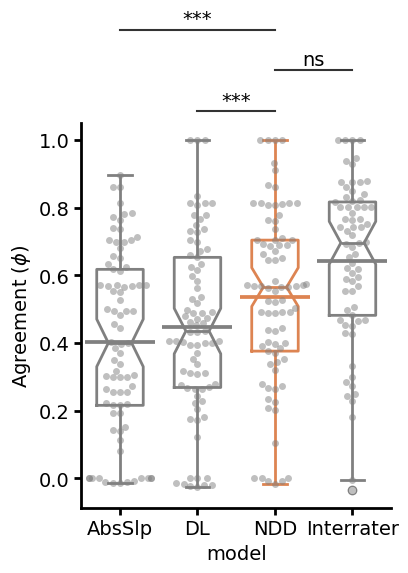

In [ ]:
# Create comprehensive model comparison visualization
colors = np.array(sns.color_palette("deep", 4))
colors = colors[[1]]  # Extract color for NDD model highlighting
_,ax = plt.subplots(figsize=(4,5))

# Multi-layer visualization: individual points + means + distribution
sns.swarmplot(all_plot_agreements,x='model',y='MCC',color='gray', order = ['AbsSlp','DL','NDD','Interrater'],alpha=0.5)
sns.pointplot(all_plot_agreements,x='model',y='MCC',palette=np.vstack([[.5,.5,.5],[.5,.5,.5],colors,[.5,.5,.5]]),
              order = ['AbsSlp','DL','NDD','Interrater'],marker='_',markersize=50,errorbar=None)  # Mean indicators
sns.boxplot(all_plot_agreements,x='model',y='MCC',palette=np.vstack([[.5,.5,.5],[.5,.5,.5],colors,[.5,.5,.5]]),
                 order=['AbsSlp','DL','NDD','Interrater'],width=.6,notch=True,fill=False)  # Quartile distributions
sns.despine()

# Add statistical significance annotations for key comparisons
annotator = Annotator(ax,[('NDD','DL'),('NDD','AbsSlp'),('NDD','Interrater')],data=all_plot_agreements,x='model',y='MCC')
annotator.configure(test=None,comparisons_correction=None,loc='outside',text_format='star',fontsize=14,
        pvalue_thresholds=[[1e-4, "****"], [1e-3, "***"], [1e-2, "**"], [0.05, "*"],[1, "ns"]],
        text_offset=1,line_offset=-2,line_height=0)
annotator.set_pvalues([0.0006,0.0003,0.06])  # P-values from R mixed-effects analysis
annotator.annotate()

plt.ylabel('Agreement ($\phi$)')  # φ symbol for MCC coefficient
plt.savefig(ospj(figpath,'figure_2_D.pdf'),bbox_inches='tight')

# Calculate sample size overlaps between models for statistical interpretation
model_classes = all_plot_agreements['model'].unique()
print("Number of annotated seizures (rows) shared between each model class:")
for i, model1 in enumerate(model_classes):
    for j, model2 in enumerate(model_classes):
        if 'Interrater' in [model1,model2]:  # Skip interrater comparisons
            continue
        if j <= i:  # Avoid duplicate pairs
            continue
        # Count seizures evaluated by both models
        ids1 = set(all_plot_agreements[all_plot_agreements['model'] == model1]['approximate_onset'])
        ids2 = set(all_plot_agreements[all_plot_agreements['model'] == model2]['approximate_onset'])
        shared = ids1 & ids2
        print(f"{model1} vs {model2}: n = {len(shared)}")

In [23]:
# Generate summary statistics for each model's agreement performance
def summary_fun(group):
    x = group['MCC']  # Changed from 'dice' to 'MCC' to match actual column name
    med = np.round(x.median(),2)  # Median agreement score
    lower = np.round(np.nanpercentile(x,25,method='nearest'),2)  # 25th percentile (Q1)
    upper = np.round(np.nanpercentile(x,75,method='nearest'),2)  # 75th percentile (Q3)
    print(f"{group.model.iloc[0]}: Med {med} [{lower}, {upper}]")  # Report median [IQR]
    return None

all_plot_agreements.groupby('model').apply(summary_fun)

AbsSlp: Med 0.4 [0.22, 0.62]
DL: Med 0.44 [0.27, 0.65]
Interrater: Med 0.7 [0.48, 0.82]
NDD: Med 0.57 [0.38, 0.7]


""


#### Stim vs. Spont

Compare model agreement performance between stimulated and spontaneous seizures to assess if stimulation affects detection accuracy.

In [24]:
# Calculate sample sizes for stimulated vs spontaneous seizure comparison
ndd_stim = all_plot_agreements[(all_plot_agreements.stim == 1) & (all_plot_agreements.model == 'NDD')]
ndd_nonstim = all_plot_agreements[(all_plot_agreements.stim == 0) & (all_plot_agreements.model == 'NDD')]
print(f"NDD stim group n = {len(ndd_stim)}")      # Number of stimulated seizures
print(f"NDD non-stim group n = {len(ndd_nonstim)}")  # Number of spontaneous seizures


NDD stim group n = 37
NDD non-stim group n = 44


p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       x: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:5.283e-01 U_stat=8.810e+02


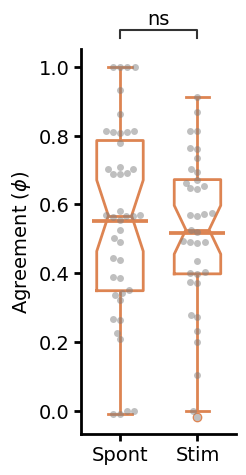

In [25]:
# Visualize NDD model performance: stimulated vs spontaneous seizures
fig,ax=plt.subplots(figsize=(2,5))
colors = np.array(sns.color_palette("deep", 4))
colors = colors[[1,1]]  # Use same color for both groups
stim_plot_agreements = all_plot_agreements[all_plot_agreements.model == 'NDD']

# Multi-layer visualization: points + means + distributions
sns.swarmplot(stim_plot_agreements,x='stim',y='MCC',color='gray',alpha=0.5)  # Individual data points
sns.pointplot(stim_plot_agreements,x='stim',y='MCC',palette=colors,
            marker='_',markersize=40,errorbar=None,estimator='mean')  # Mean values
sns.boxplot(stim_plot_agreements,x='stim',y='MCC',palette=colors,width=.6,notch=True,fill=False)  # Distribution quartiles

sns.despine()
plt.xticks([0,1],['Spont','Stim'])  # Clear group labels
plt.xlabel('')
plt.ylabel('Agreement ($\phi$)')

# Statistical comparison using Mann-Whitney U test (non-parametric)
annotator = Annotator(ax,[(True,False)],data=stim_plot_agreements,x='stim',y='MCC')
annotator.configure(test='Mann-Whitney',loc='outside',text_format='star',fontsize=14,
        pvalue_thresholds=[[1e-4, "****"], [1e-3, "***"], [1e-2, "**"], [0.05, "*"], [0.1, "x"],[1, "ns"]])
annotator.apply_and_annotate()  # Automatically calculates and displays p-value
plt.savefig(ospj(figpath,'figure_2_E.pdf'),bbox_inches='tight')

In [26]:
# Export stimulated vs spontaneous seizure comparison data for advanced statistical analysis
# This enables mixed-effects modeling to control for patient-specific effects in R
stim_vs_spont_agreements = stim_plot_agreements.copy()
stim_vs_spont_agreements['analysis_type'] = 'stim_vs_spontaneous'  # Label analysis type
stim_vs_spont_agreements.to_csv(ospj(prodatapath, 'stim_vs_spont_agreements_for_lme.csv'), index=False)
print(f"Saved stim vs spontaneous agreements to {ospj(prodatapath, 'stim_vs_spont_agreements_for_lme.csv')}")
print(f"Columns: {list(stim_vs_spont_agreements.columns)}")
print(f"Shape: {stim_vs_spont_agreements.shape}")
print(f"Sample data:")
print(stim_vs_spont_agreements.head())

Saved stim vs spontaneous agreements to /Users/wojemann/Documents/CNT/stim_seizures_data/PROCESSED_DATA/stim_vs_spont_agreements_for_lme.csv
Columns: ['index', 'patient', 'iEEG_ID', 'model', 'stim', 'approximate_onset', 'ueo_time_consensus', 'threshold', 'ueo_chs_strict', 'ueo_chs_loose', 'sec_chs_strict', 'sec_chs_loose', 'to_annotate', 'all_chs', 'ueo_consensus', 'ueo_any', 'sec_consensus', 'sec_any', 'ueo_chs_strict_bool', 'ueo_chs_strict_any_MCC', 'ueo_chs_loose_bool', 'ueo_chs_loose_consensus_MCC', 'ueo_chs_loose_any_MCC', 'sec_chs_strict_bool', 'sec_chs_strict_any_MCC', 'sec_chs_loose_bool', 'sec_chs_loose_consensus_MCC', 'sec_chs_loose_any_MCC', 'annot', 'MCC', 'analysis_type']
Shape: (81, 31)
Sample data:
    index  patient       iEEG_ID model  stim  approximate_onset  \
2     2.0  CHOP005       CHOP005   NDD   1.0           68881.53   
5     5.0  CHOP010  CHOPCCEP_010   NDD   1.0            2230.26   
8     8.0  CHOP024  CHOPCCEP_024   NDD   1.0           87579.25   
11   11.0